<a href="https://colab.research.google.com/github/hillalalhamdi/DataMiningKlasifikasi/blob/main/PDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA**

In [ ]:
# === Import Library ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, when, count, isnan, udf
from pyspark.sql.types import StringType, IntegerType
spark = SparkSession.builder.appName("NetflixReviewEDA").getOrCreate()

In [ ]:
df = spark.read.option("header", True).csv("netflix_reviews.csv")
df.printSchema()
df.show(5)

In [ ]:
# Cek null per kolom
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

# Drop duplikat
df = df.dropDuplicates()


In [ ]:
df.groupBy("score").count().orderBy("score").show()

In [ ]:
df = df.withColumn("content_length", length(col("content")))
df.select("content_length").describe().show()

In [ ]:
def score_to_sentiment(score):
    if score is None:
        return None
    try:
        r = int(score)
        if r >= 4:
            return "positive"
        elif r == 3:
            return "neutral"
        else:
            return "negative"
            #invalid=anomaly
    except ValueError:
        return "invalid"
sentiment_udf = udf(score_to_sentiment, StringType())
df = df.withColumn("sentiment", sentiment_udf(col("score")))
df.groupBy("sentiment").count().show()

In [ ]:
df.groupBy("sentiment").agg({"content_length": "avg"}).show()

In [ ]:
from pyspark.sql.functions import to_date, month, year

df = df.withColumn("at", to_date(col("at")))
df.groupBy(year("at").alias("year"), month("at").alias("month")) \
  .agg({"score": "avg"}).orderBy("year", "month").show()

In [ ]:
df_pandas = df.select("score", "sentiment").toPandas()
print(df_pandas.head())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="sentiment", data=df_pandas)
plt.show()

# **PREPROCESSING DATA**

In [ ]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def clean_text(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)  # remove HTML tags
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabet characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

clean_udf = udf(clean_text, StringType())
df = df.withColumn("clean_sentiment", clean_udf(col("sentiment")))
print(df.select("sentiment", "clean_sentiment").show(5))

+---------+---------------+
|sentiment|clean_sentiment|
+---------+---------------+
| negative|       negative|
|  neutral|        neutral|
|  neutral|        neutral|
| negative|       negative|
| positive|       positive|
+---------+---------------+
only showing top 5 rows

None


In [ ]:
if 'label' in df.columns:
    df = df.drop('label')

indexer = StringIndexer(inputCol="sentiment", outputCol="label", handleInvalid="keep")
df = indexer.fit(df).transform(df)
num_classes = df.select("label").distinct().count()

df_model = df.select("clean_sentiment", "label").toPandas()
print(df_model.head())

  clean_sentiment  label
0        negative    0.0
1         neutral    2.0
2         neutral    2.0
3        negative    0.0
4        positive    1.0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_model['clean_sentiment'])

sequences = tokenizer.texts_to_sequences(df_model['clean_sentiment'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post')

# Siapkan label
labels = df_model['label'].values
print(padded_sequences)
print(labels)

[[2 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]
[0. 2. 2. ... 0. 0. 1.]


# **MODELING & EVALUASI**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Initialize the Sequential model
model = Sequential()

model.add(Dense(64, activation='relu'))
num_classes = df.select("label").distinct().count()
model.add(Dense(num_classes, activation='softmax'))
print(num_classes)

5


In [ ]:
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import when

max_class_index = num_classes - 1  # Maximum expected class index
df = df.withColumn(
    "label",
    when(df["label"] > max_class_index, max_class_index).otherwise(df["label"]),
)

# Now, regenerate your training and test data from the modified DataFrame:
df_model = df.select("clean_sentiment", "label").toPandas()

# ... (Your code for tokenization and padding) ...

# Use padded_sequences instead of padded
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)
print(X_train)
print(y_train)

[[2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]
[0. 0. 1. ... 0. 0. 1.]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output kelas
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Before fitting the StringIndexer, check if 'label' column exists and drop if necessary
if 'label' in df.columns:
    df = df.drop('label')

# Now fit the StringIndexer and proceed with the rest of your code
indexer = StringIndexer(inputCol="sentiment", outputCol="label", handleInvalid="keep")
df = indexer.fit(df).transform(df)

# After fitting StringIndexer check and adjust your model's output layer
num_classes = df.select("label").distinct().count()

model.add(Dense(num_classes, activation='softmax'))

233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.4963 - loss: 1.5108
Loss pada data uji: 1.5090
Akurasi pada data uji: 0.4997
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67      3726
     Neutral       0.00      0.00      0.00      3002
    Positive       0.00      0.00      0.00       558
     Invalid       0.00      0.00      0.00       170

    accuracy                           0.50      7456
   macro avg       0.12      0.25      0.17      7456
weighted avg       0.25      0.50      0.33      7456



Text(0.5, 36.72222222222221, 'Predicted')

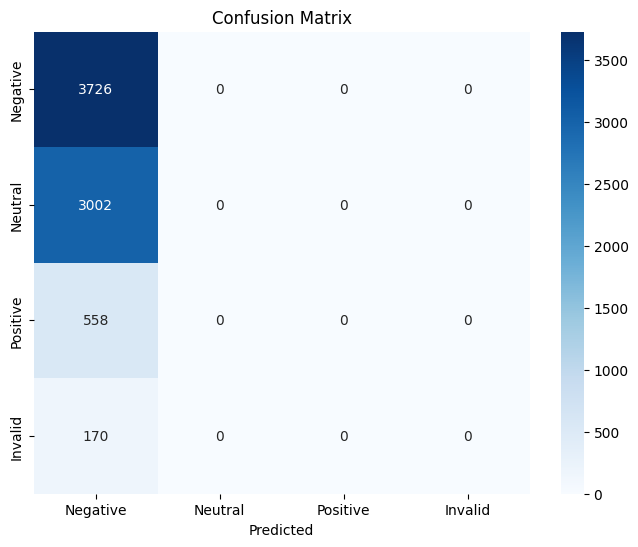

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluasi dasar
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss pada data uji: {loss:.4f}")
print(f"Akurasi pada data uji: {accuracy:.4f}")

# Prediksi probabilitas
y_pred_probs = model.predict(X_test)

# Ambil kelas dengan probabilitas tertinggi
y_pred = np.argmax(y_pred_probs, axis=1)

# Laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive", "Invalid"], zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix - Update xticklabels and yticklabels as well
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive", "Invalid"], yticklabels=["Negative", "Neutral", "Positive", "Invalid"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')